# TP - Réseau de Neurones
> By: Omar ALLOUCH - Mathieu SROUR

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

In [340]:
data = pd.read_csv('HD_Complete_Data.csv', sep=';')

## Exploratory Data Analysis

In [341]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [342]:
categorical_variables = ['Sexe', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS', 'HeartDisease']
data[categorical_variables] = data[categorical_variables].astype('category')

In [343]:
data.isnull().sum()

Age               0
Sexe              0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

No null values in the data.

**Distribution of numerical features**

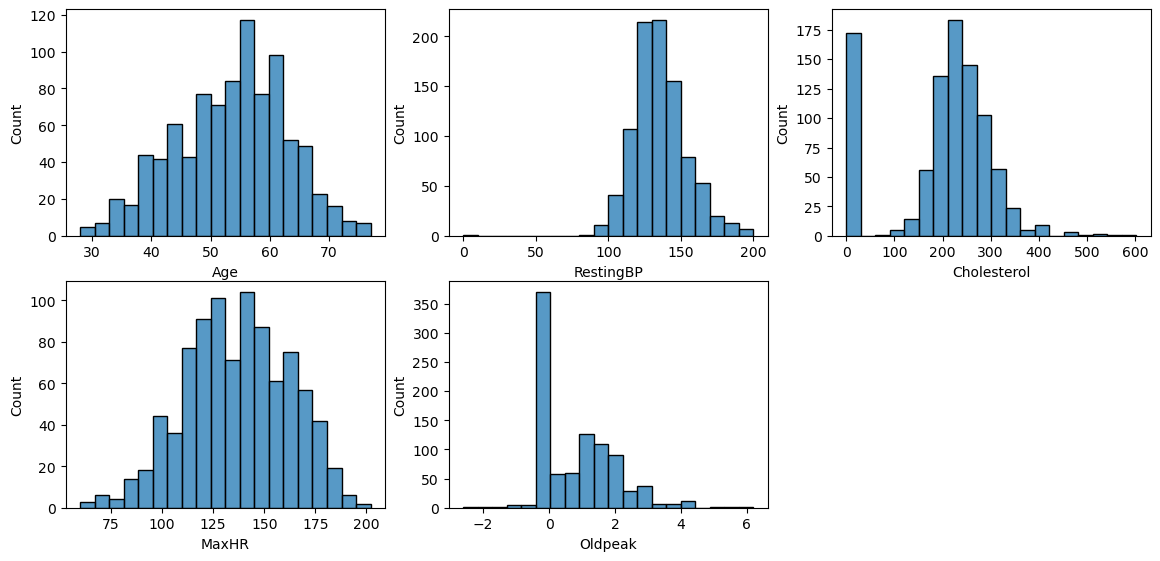

In [344]:
numerical_data = data.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_data.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=numerical_data, x=col, bins=20)

* **Oldpeak** distribution is right-skewed.
* **Cholesterol** has a bimodal distribution.

**Boxplots**

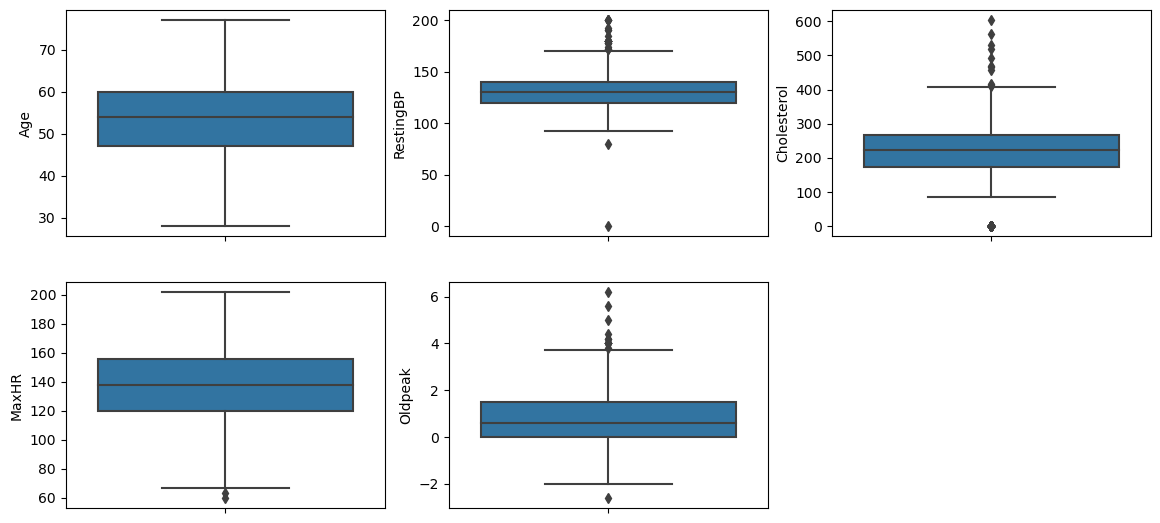

In [345]:
plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_data.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=col, data=numerical_data)

**Categorical variables**

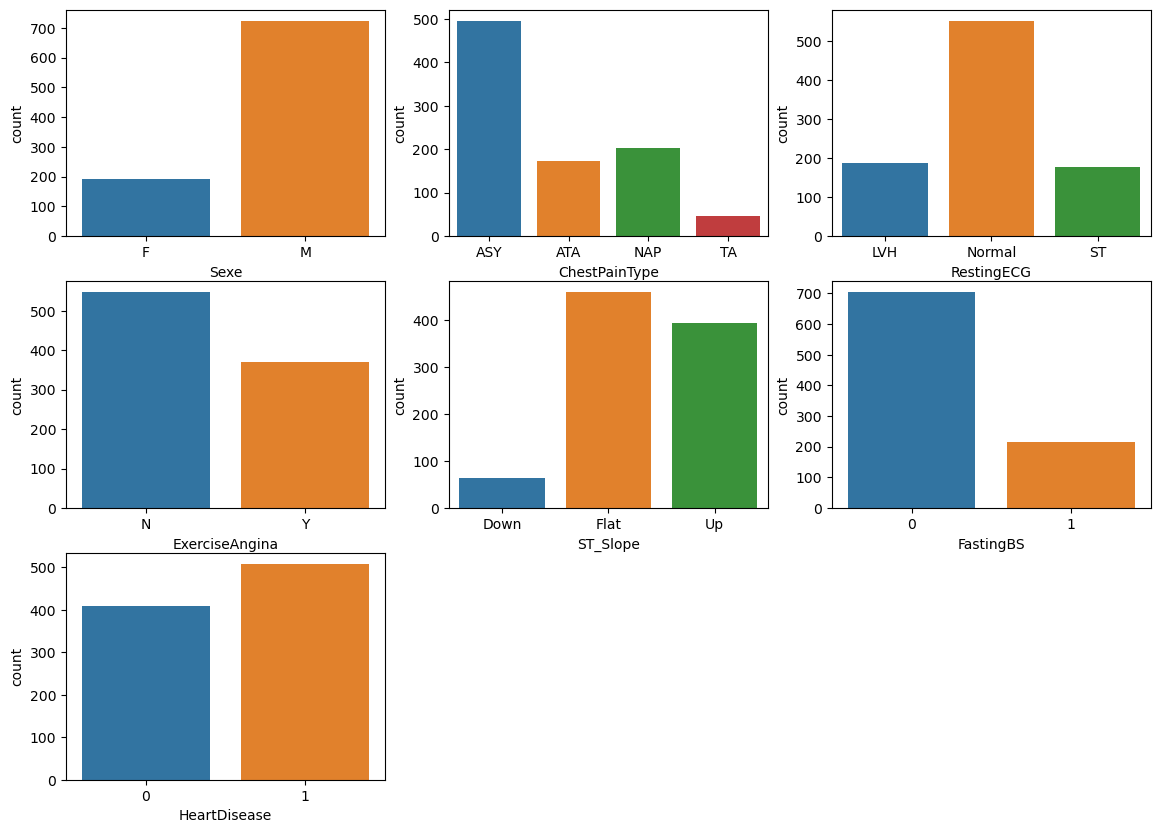

In [346]:
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_variables):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=col, data=data)

**Target variable**

Text(0.5, 1.0, 'Heart Disease')

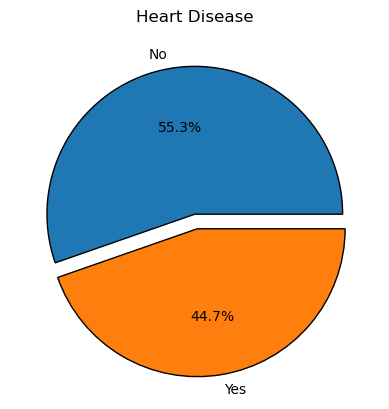

In [347]:
plt.pie(data['HeartDisease'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%', explode=[0, 0.1], wedgeprops={'edgecolor': 'black'})
plt.title('Heart Disease')

**Categorical variables vs target variable**

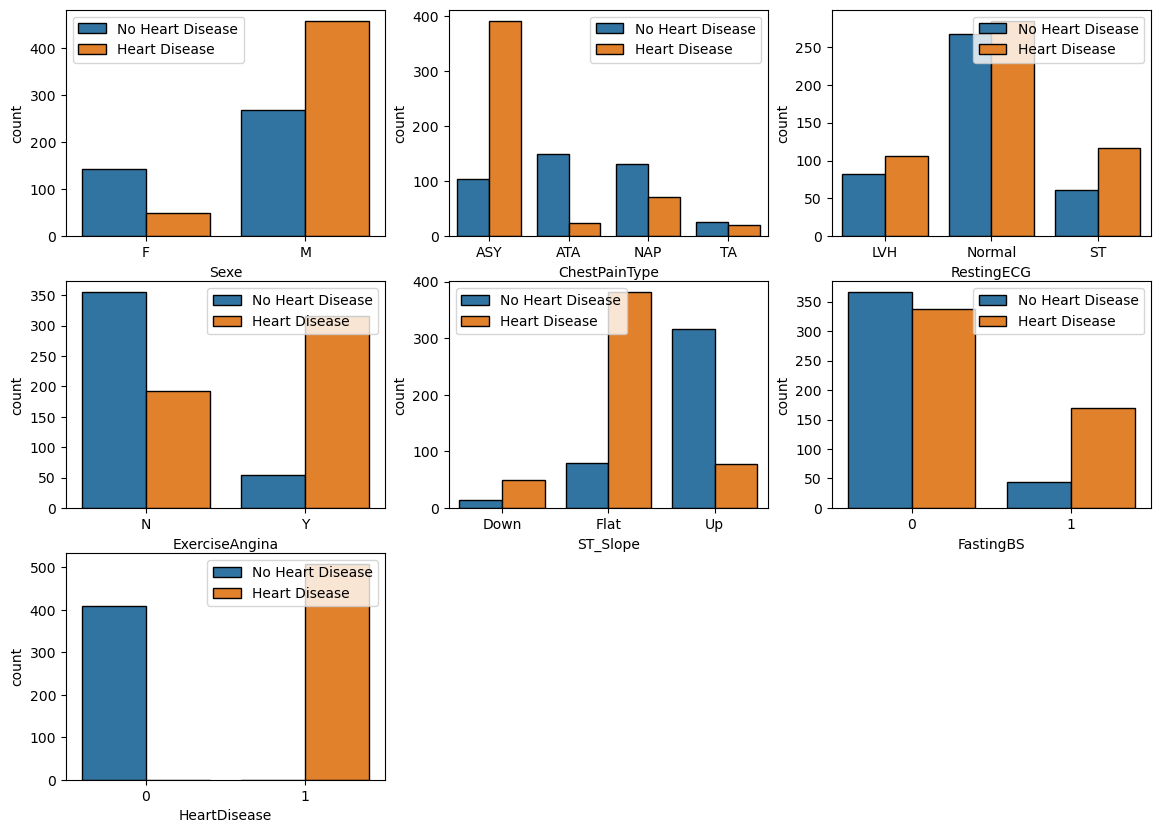

In [348]:
# Categorical variables vs target variable
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_variables):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=col, hue='HeartDisease', data=data, edgecolor='black')
    plt.legend(['No Heart Disease', 'Heart Disease'])

* **Males** population has more _heart disease_ individuals than _no heart disease_. The opposite is for **Females**.
* **ASY** _chest pain type_ is a strong indicator of a _heart disease_.
* **ExerciseAngina** greatly suggests a _heart disease_.
* In **ST_Slope**, a **flat** slope indicates a _heart disease_, same for **down**.
* **RestingECG** and **FastingBS** are not so clear.

**Correlations**

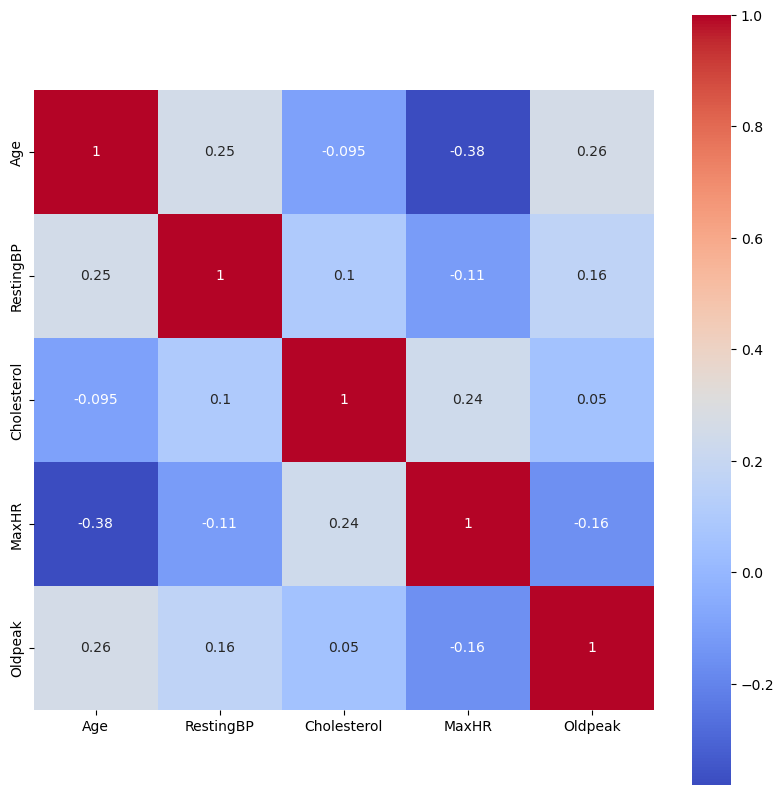

In [349]:
corr = numerical_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, square=True, cmap='coolwarm')
plt.show()

No major correlations, we will keep all the numerical variables.

**Pairplot of numerical variables**

/home/omar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


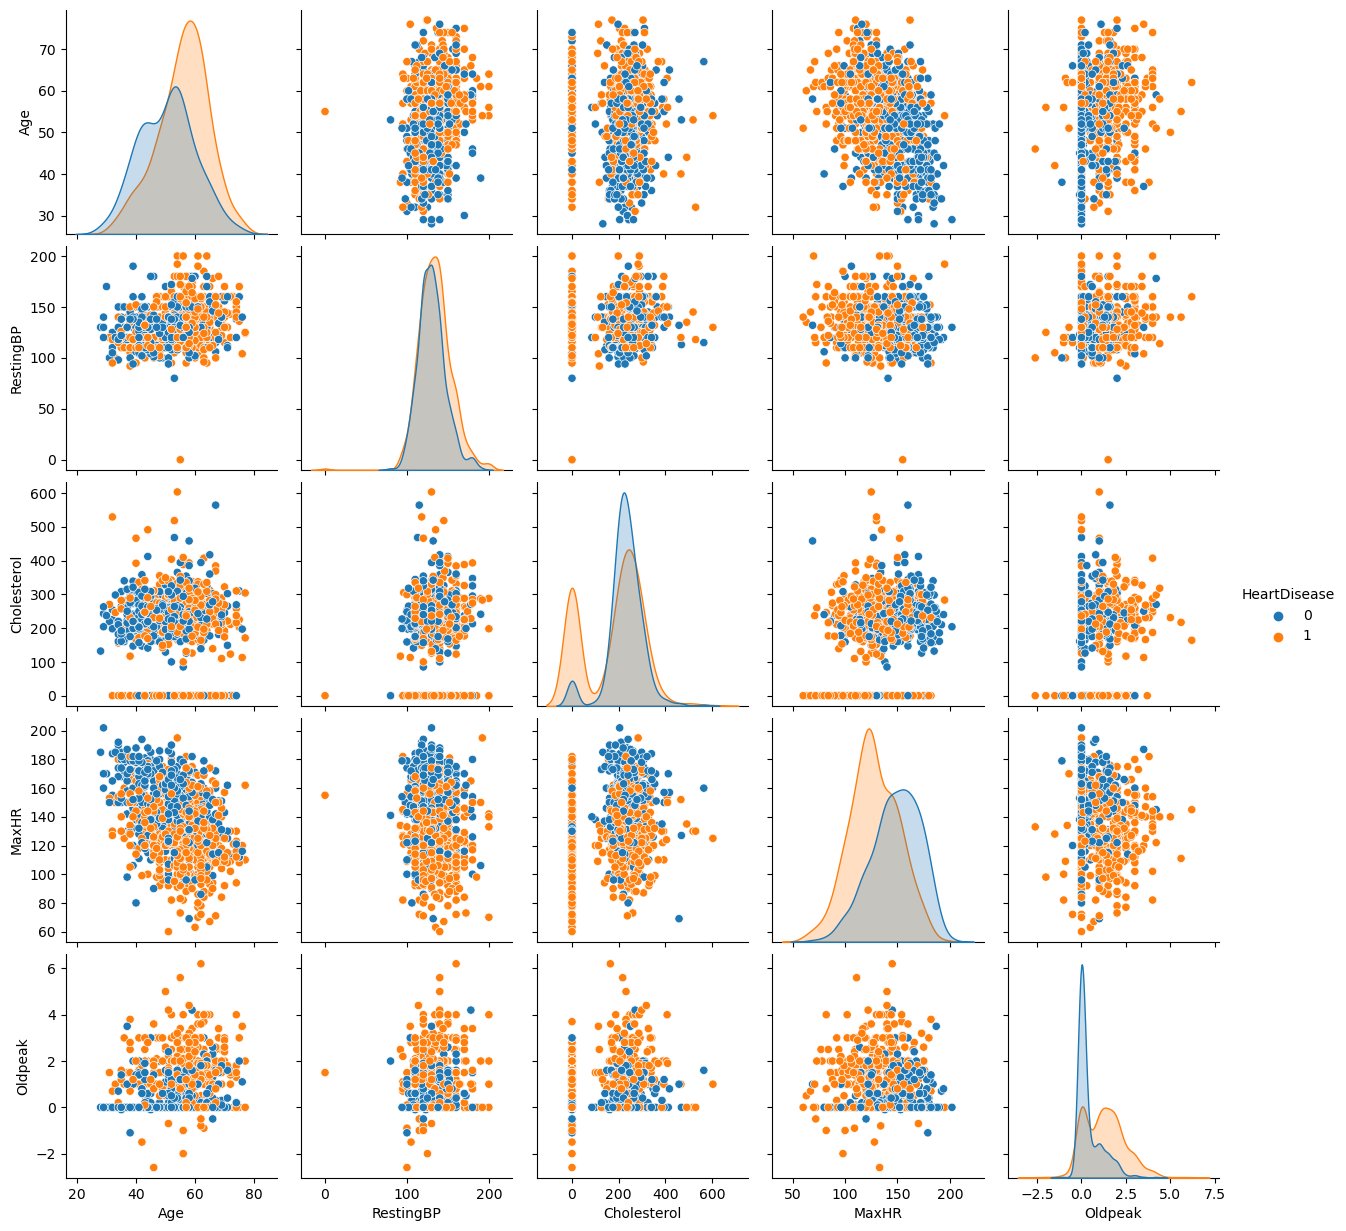

In [350]:
sns.pairplot(data, hue='HeartDisease')

From the various plots we obtained, we can distinguish some outliers, and we shall handle those.

Furthermore, the scale of variables is not the same which would negatively affect the performance, so we will opt to standardize those.

## Data Preprocessing

Removing outliers

In [351]:
data = data[data['RestingBP'] > 50]

In [352]:
X, y = data.drop('HeartDisease', axis=1), data['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (733, 11)
X_test shape: (184, 11)


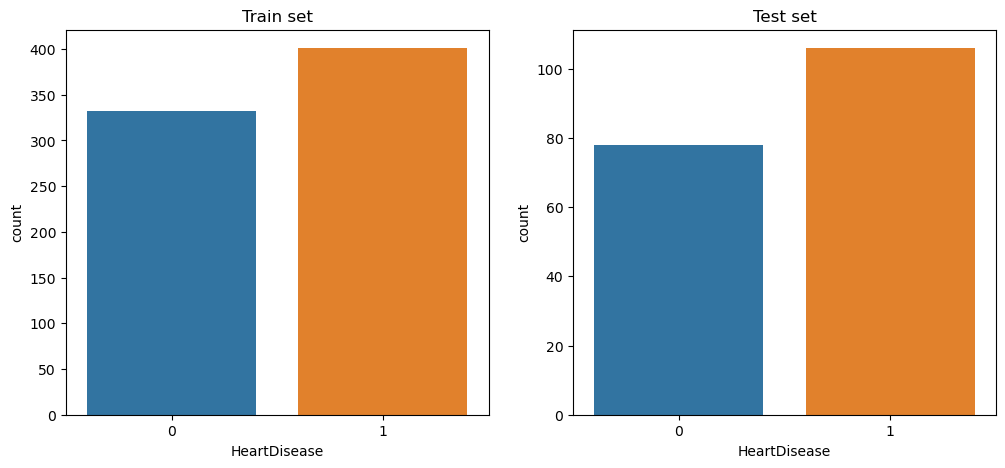

In [353]:
# Plot the distribution of the target variable for train and test sets
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Train set')
plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Test set')
plt.show()

Notice how we kept the same proportion of the target variable in both train and test sets.

Now we scale our variables for the reasons mentioned above.

In [354]:
scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

numerical_data = X_train.select_dtypes(include=['int64', 'float64']).drop('Oldpeak', axis=1)
X_train[numerical_data.columns] = scaler.fit_transform(numerical_data)
X_train['Oldpeak'] = min_max_scaler.fit_transform(X_train[['Oldpeak']])

numerical_data = X_test.select_dtypes(include=['int64', 'float64']).drop('Oldpeak', axis=1)
X_test[numerical_data.columns] = scaler.fit_transform(numerical_data)
X_test['Oldpeak'] = min_max_scaler.fit_transform(X_test[['Oldpeak']])

We'll one-hot encode our categorical variables, so as to not give any unwanted importance for any category over the others.

In [355]:
# One-hot encoding
categorical_variables = ['Sexe', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']

one_hot_encoded = pd.get_dummies(X_train[categorical_variables], prefix=categorical_variables)
X_train = pd.concat([X_train, one_hot_encoded], axis=1)
X_train.drop(columns=categorical_variables, axis=1, inplace=True)
X_train = np.asarray(X_train).astype('float32')

one_hot_encoded = pd.get_dummies(X_test[categorical_variables], prefix=categorical_variables)
X_test = pd.concat([X_test, one_hot_encoded], axis=1)
X_test.drop(columns=categorical_variables, axis=1, inplace=True)
X_test = np.asarray(X_test).astype('float32')

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (733, 21)
X_test shape: (184, 21)


The number of columns increased from 11 to 21 (variables), which is inline with the number of categories of different variables.

## Model training

In [356]:
# Set the seed for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Construct the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 21)                462       
                                                                 
 dense_113 (Dense)           (None, 32)                704       
                                                                 
 dense_114 (Dense)           (None, 64)                2112      
                                                                 
 dense_115 (Dense)           (None, 32)                2080      
                                                                 
 dense_116 (Dense)           (None, 1)                 33        
                                                                 
Total params: 5,391
Trainable params: 5,391
Non-trainable params: 0
_________________________________________________________________


We will be adding an `early_stopping` criteria to prevent the model from overfitting. Another way would be to add some `Dropout` layers, however, by doing some trial and error the early stopping seemed to do the job and produce better results.

Epoch 1/100


19/19 [==============================] - 1s 27ms/step - loss: 0.6491 - accuracy: 0.6672 - val_loss: 0.6010 - val_accuracy: 0.7551
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5198 - accuracy: 0.8430 - val_loss: 0.4980 - val_accuracy: 0.7755
Epoch 3/100
19/19 [==============================] - 0s 12ms/step - loss: 0.3898 - accuracy: 0.8567 - val_loss: 0.4615 - val_accuracy: 0.7891
Epoch 4/100
19/19 [==============================] - 0s 10ms/step - loss: 0.3331 - accuracy: 0.8618 - val_loss: 0.4495 - val_accuracy: 0.7959
Epoch 5/100
19/19 [==============================] - 0s 15ms/step - loss: 0.3217 - accuracy: 0.8788 - val_loss: 0.4601 - val_accuracy: 0.7959
Epoch 6/100
19/19 [==============================] - 0s 13ms/step - loss: 0.3131 - accuracy: 0.8754 - val_loss: 0.4276 - val_accuracy: 0.8095
Epoch 7/100
19/19 [==============================] - 0s 11ms/step - loss: 0.3072 - accuracy: 0.8823 - val_loss: 0.4351 - val_accuracy: 0.7959
Epoch 8/100
19/19 

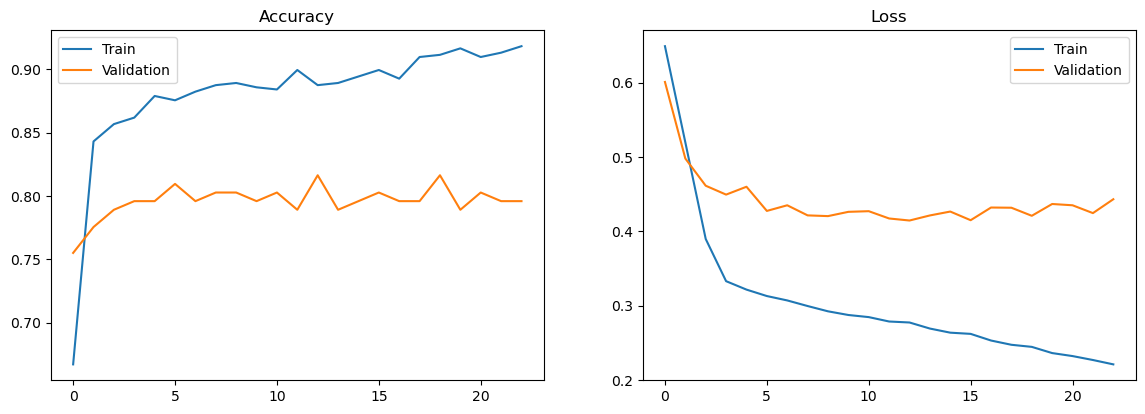

In [357]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping], use_multiprocessing=True)

# Plot the learning curves
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 0s 5ms/step - loss: 0.3454 - accuracy: 0.8804


6/6 [==============================] - 0s 3ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85        78
           1       0.86      0.95      0.90       106

    accuracy                           0.88       184
   macro avg       0.89      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



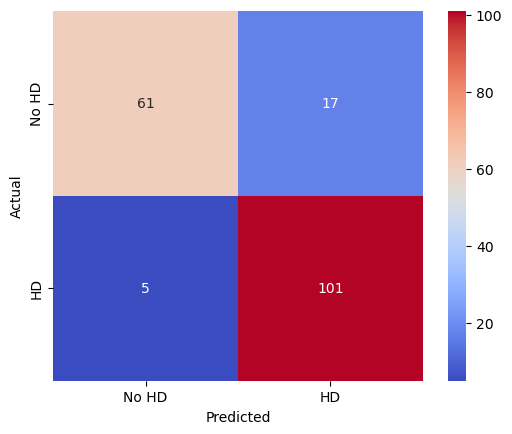

In [358]:
# Evaluate the model
model.evaluate(X_test, y_test)

# Make predictions
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

print("Classification report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, square=True, cmap='coolwarm', fmt='d', xticklabels=['No HD', 'HD'], yticklabels=['No HD', 'HD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

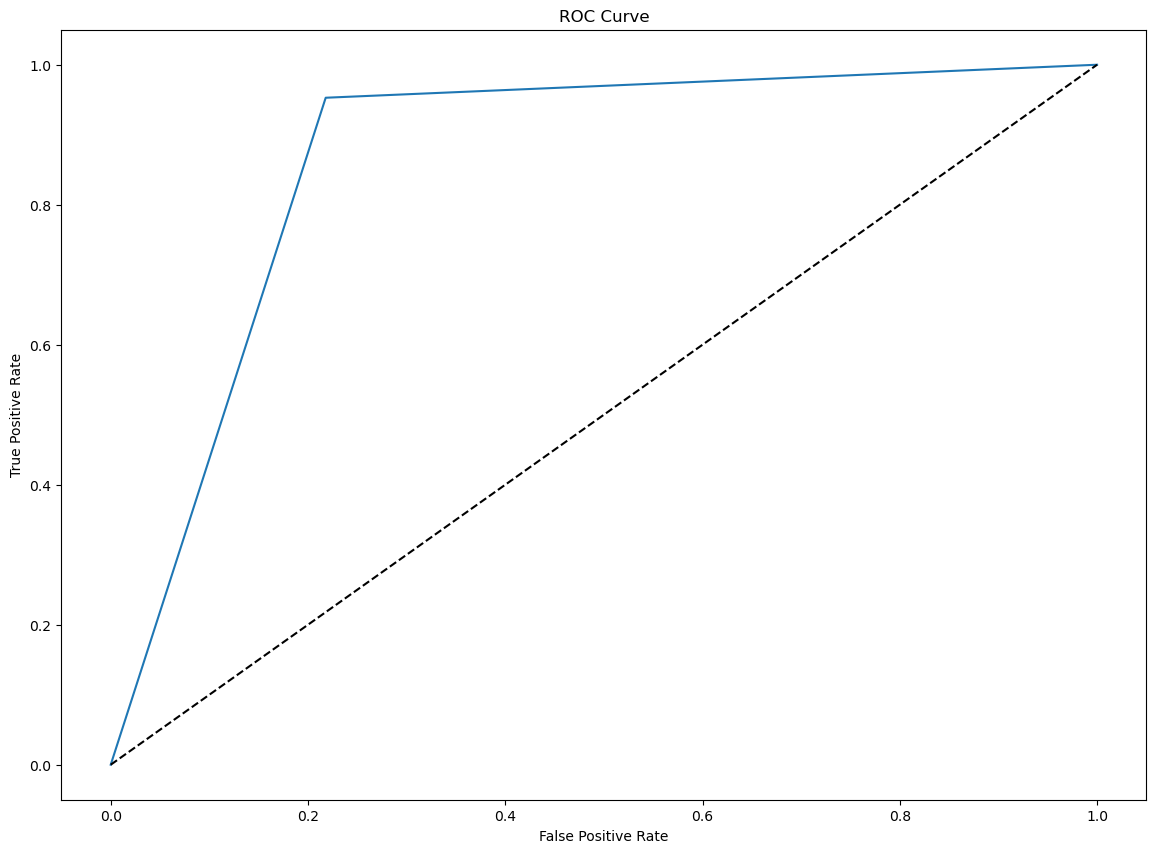

AUC Score:  0.8674407353652636


In [359]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(14, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute the AUC score
print("AUC Score: ", roc_auc_score(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        78
           1       0.86      0.91      0.88       106

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



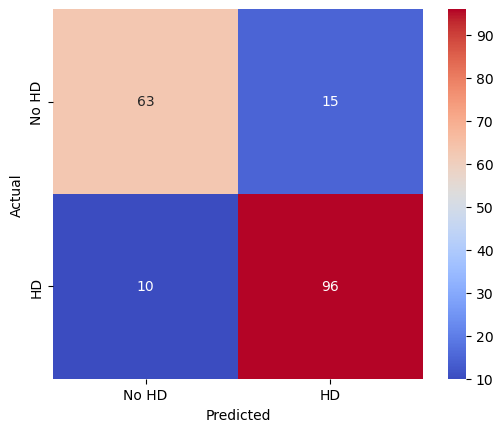

AUC Score:  0.8566763425253991


In [361]:
# Logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

print("Classification report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, square=True, cmap='coolwarm', fmt='d', xticklabels=['No HD', 'HD'], yticklabels=['No HD', 'HD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute the AUC score
print("AUC Score: ", roc_auc_score(y_test, y_pred))

## Results


Recap of results:
- NN: accuracy = 88%, auc = 0.87
- Logistic regression: accuracy = 86%, auc = 0.8566

These 2 metrics may seem very close, however we should also take a look at the precision, recall, and f1-score which are better for the NN. Moreover, the NN had less false negatives, which is critical in this kind of applications. The major disadvantage is the huge number of parameters in the NN, and some would argue that the results are not worth it. Personally, I see that the NN is still better, and with hyper-parameter tuning we could come up with even better results, while always retaining a low false negative rate, which would allow us to rely more on the model for real-life predictions.

On another note, it could be interesting to look at the results of models such as: SVM (SVC), RandomForest, XGBoost...etc and compare the results.